In [1]:
%reload_ext autoreload
%autoreload 2

import string
from fastai import *
from fastai.vision import *
from fastai.tabular import *
from fastai.tabular.data import *
from sklearn.model_selection import train_test_split

In [2]:
PATH = Path("data/vdjdb-2018-06-04")
tcr = pd.read_csv(PATH/"vdjdb.slim.txt", sep="\t")
tcr.head()

,gene,cdr3,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v.segm,j.segm,v.end,j.start,mhc.a,mhc.b,mhc.class,reference.id,vdjdb.score
0,TRB,CASSFSGTQYF,HomoSapiens,NLVPMVATV,p65,CMV,0,TRBV28*01,TRBJ2-3*01,4,7,HLA-A*02,B2M,MHCI,PMID:28423320,0
1,TRB,CASSQVEEFHGELFF,HomoSapiens,GILGFVFTL,M1,InfluenzaA,0,TRBV7-9*01,TRBJ2-2*01,4,10,HLA-A*02,B2M,MHCI,PMID:28423320,0
2,TRB,CASSMSRSSNQPQYF,MacacaMulatta,TTPESANL,Tat,SIV,0,TRBV14*01,TRBJ1-5*01,4,8,Mamu-A*01,B2M,MHCI,PMID:15589168,0
3,TRB,CASSPRQGLEGANVLTF,HomoSapiens,LPPIVAKEI,Int,HIV-1,0,TRBV7-9*01,TRBJ2-6*01,4,10,HLA-B*42:01,B2M,MHCI,PMID:25911754,0
4,TRB,CASSLGSQNTLYF,MusMusculus,HGIRNASFI,M45,MCMV,"1962,1907,1926,1914,1969",TRBV12-1*01,TRBJ2-4*01,5,6,H-2Db,B2M,MHCI,PMID:28636592,1


In [3]:
# human only
tcr_human = tcr[tcr["species"]=="HomoSapiens"]
len(tcr_human)

20941

In [4]:
# TRB chain only
tcr_human_b = tcr_human[tcr_human["gene"]=="TRB"]
len(tcr_human_b)

14941

In [5]:
epitope_counts = tcr_human_b["antigen.epitope"].value_counts()
epitope_counts[:10]

NLVPMVATV               4459
GILGFVFTL               2678
ELAGIGILTV               976
GLCTLVAML                863
LLWNGPMAV                409
FRDYVDRFYKTLRAEQASQE     390
KRWIILGLNK               328
PKYVKQNTLKLAT            295
LLLGIGILV                233
TPRVTGGGAM               206
Name: antigen.epitope, dtype: int64

In [6]:
# the database is dominated by two epitopes: NLVPMVATV and GILGFVFTL
# build a basic classifier for those two classes

In [7]:
tcr_human_b_2 = tcr_human_b[tcr_human_b["antigen.epitope"].isin(
    epitope_counts.index.values[:2])]
len(tcr_human_b_2)   

7137

In [8]:
# unique epitopes, should be NLVPMVATV and GILGFVFTL
tcr_human_b_2["antigen.epitope"].unique()

array(['NLVPMVATV', 'GILGFVFTL'], dtype=object)

In [9]:
# replicate GILGFVFTL to make the dataset more balanced
tcr_human_b_2 = pd.concat([tcr_human_b_2, tcr_human_b_2[tcr_human_b_2["antigen.epitope"]=="GILGFVFTL"]])
len(tcr_human_b_2)

9815

In [10]:
tcr_human_b_2["antigen.epitope"].value_counts()

GILGFVFTL    5356
NLVPMVATV    4459
Name: antigen.epitope, dtype: int64

In [11]:
# baseline accuracy
5356/(4459+5356)

0.5456953642384106

In [12]:
# for now only analyze CD8 TCRs
tcr_human_b_2_cd8 = tcr_human_b_2[tcr_human_b_2["mhc.class"]=="MHCI"]
len(tcr_human_b_2_cd8)

9815

In [13]:
# mhc b should all be B2M
tcr_human_b_2_cd8["mhc.b"].value_counts()

B2M    9815
Name: mhc.b, dtype: int64

In [14]:
# unique v genes
len(tcr_human_b_2_cd8["v.segm"].unique())

89

In [15]:
# unique j genes
len(tcr_human_b_2_cd8["j.segm"].unique())

23

In [16]:
# unique mhc a
len(tcr_human_b_2_cd8["mhc.a"].unique())

7

In [17]:
# max CDR3 length
tcr_human_b_2_cd8["cdr3"].str.len().max()

38

In [18]:
# padding
tcr_human_b_2_cd8["cdr3_pad"] = tcr_human_b_2_cd8["cdr3"].str.ljust(38, "0")
tcr_human_b_2_cd8.head()

,gene,cdr3,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v.segm,j.segm,v.end,j.start,mhc.a,mhc.b,mhc.class,reference.id,vdjdb.score,cdr3_pad
0,TRB,CASSFSGTQYF,HomoSapiens,NLVPMVATV,p65,CMV,0,TRBV28*01,TRBJ2-3*01,4,7,HLA-A*02,B2M,MHCI,PMID:28423320,0,CASSFSGTQYF000000000000000000000000000
1,TRB,CASSQVEEFHGELFF,HomoSapiens,GILGFVFTL,M1,InfluenzaA,0,TRBV7-9*01,TRBJ2-2*01,4,10,HLA-A*02,B2M,MHCI,PMID:28423320,0,CASSQVEEFHGELFF00000000000000000000000
10,TRB,CASSEIGWGEQYF,HomoSapiens,NLVPMVATV,p65,CMV,0,TRBV11-2*01,TRBJ2-7*01,4,9,HLA-A*02,B2M,MHCI,PMID:28423320,0,CASSEIGWGEQYF0000000000000000000000000
15,TRB,CSARDIEIAYEQYF,HomoSapiens,NLVPMVATV,p65,CMV,0,TRBV20-1*01,TRBJ2-7*01,4,9,HLA-A*02,B2M,MHCI,PMID:28423320,0,CSARDIEIAYEQYF000000000000000000000000
17,TRB,CASSRTSGGLNEQFF,HomoSapiens,GILGFVFTL,M1,InfluenzaA,0,TRBV19*01,TRBJ2-1*01,4,10,HLA-A*02,B2M,MHCI,PMID:28423320,0,CASSRTSGGLNEQFF00000000000000000000000


In [19]:
# drop unused columns
tcr_human_b_2_cd8 = tcr_human_b_2_cd8[["cdr3_pad", "antigen.epitope", "v.segm", "j.segm", "mhc.a"]]

In [20]:
tcr_human_b_2_cd8.head()

,cdr3_pad,antigen.epitope,v.segm,j.segm,mhc.a
0,CASSFSGTQYF000000000000000000000000000,NLVPMVATV,TRBV28*01,TRBJ2-3*01,HLA-A*02
1,CASSQVEEFHGELFF00000000000000000000000,GILGFVFTL,TRBV7-9*01,TRBJ2-2*01,HLA-A*02
10,CASSEIGWGEQYF0000000000000000000000000,NLVPMVATV,TRBV11-2*01,TRBJ2-7*01,HLA-A*02
15,CSARDIEIAYEQYF000000000000000000000000,NLVPMVATV,TRBV20-1*01,TRBJ2-7*01,HLA-A*02
17,CASSRTSGGLNEQFF00000000000000000000000,GILGFVFTL,TRBV19*01,TRBJ2-1*01,HLA-A*02


In [21]:
tcr_train, tcr_test = train_test_split(tcr_human_b_2_cd8, test_size=0.2)

In [22]:
len(tcr_train), len(tcr_test)

(7852, 1963)

In [23]:
class TabularTextLine(TabularLine):
    "Basic item for tabular and text data."    
    def __init__(self, cats, conts, classes, names, text_col, text_ids, text_letters):
        # tabular
        super().__init__(cats, conts, classes, names)

        # add text 
        self.text_col = text_col
        self.text_ids = text_ids
        self.text_letters = text_letters
        
        # append numericalted text data to your input (represents your X values that are fed into your model)
        self.data += [tensor(text_ids)]
        self.obj = self.data
        
    def __str__(self):
        res = super().__str__() + f'Text: {"".join(self.text_letters)}'
        return res

In [24]:
# all unique aas
cdr3_sets = tcr_human_b_2_cd8["cdr3_pad"].map(lambda cdr3: set(list(cdr3)))
unique_aas = set()
for s in cdr3_sets:
    unique_aas = unique_aas|s
len(unique_aas)

21

In [25]:
# convert letter to integer, save 0 for padding
letter_to_int = {l:i for i, l in enumerate(list(unique_aas))}

# reverse
int_to_letter = {i:l for i, l in enumerate(list(unique_aas))}

int_to_letter[letter_to_int["A"]]

'A'

In [26]:
class TabularTextProcessor(TabularProcessor):
    "Inherited from TabularProcessor to proprocess text data"
    
    def __init__(self, ds:ItemBase=None, procs=None):
        super().__init__(ds, procs)
        
    def process(self, ds):
        super().process(ds)
        
        # set preprocessed back to False for text
        ds.preprocessed = False
        
        # process text data (amino acids)
        # convert each sequence into a list of amino acids
        if len(ds.text_col) != 0:
            # each aas is a list of length 1
            ds.text_letters = [list(aas[0]) for aas in ds.xtra[ds.text_col].values]
            ds.text_ids = []
            for list_aas in ds.text_letters:
                ds.text_ids.append(np.array([letter_to_int[aa] for aa in list_aas], dtype=np.int64))
        else:
            ds.text_aas, ds.text_ids = [], []
            
        ds.preprocessed = True

In [27]:
class TabularTextList(TabularList):
    "A custom `ItemList` that merges tabular data along with textual data"
    
    _item_cls = TabularTextLine
    _processor = TabularTextProcessor
    _bunch = TabularDataBunch
    
    def __init__(self, items:Iterator, cat_names:OptStrList=None, cont_names:OptStrList=None, 
                 text_col=None, procs=None, **kwargs) -> 'TabularTextList':
        super().__init__(items, cat_names, cont_names, procs, **kwargs)
        
        # add text col
        self.text_col = text_col
        self.copy_new += ['text_col']
        self.preprocessed = False
        
    @classmethod
    def from_df(cls, df:DataFrame, cat_names:OptStrList=None, cont_names:OptStrList=None, 
                text_col=None, procs=None, **kwargs) -> 'ItemList':
        
        return cls(items=range(len(df)), cat_names=cat_names, cont_names=cont_names, 
                   text_col=text_col,procs=procs, xtra=df.copy(), **kwargs)
        
    def get(self, o):
        # copyed from fastai, not changed
        if not self.preprocessed: return self.xtra.iloc[o] if hasattr(self, 'xtra') else self.items[o]
        codes = [] if self.codes is None else self.codes[o]
        conts = [] if self.conts is None else self.conts[o]
        
        text_ids = [] if self.text_ids is None else self.text_ids[o]
        text_letters = [] if self.text_letters is None else self.text_letters[o]

        return self._item_cls(codes, conts, self.classes, self.col_names, self.text_col, text_ids, text_letters)
    
    # take a tensor t and return the same king of thing as the get method
    def reconstruct(self, t:Tensor):
        return self._item_cls(t[0], t[1], self.classes, self.col_names, self.text_col,
                              t[2], [int_to_letter[i.item()] for i in t[2]])
    
    # tells fastai how to display a custom ItemBase when data.show_batch() is called
    def show_xys(self, xs, ys) -> None:
        "Show the `xs` (inputs) and `ys` (targets)."
        from IPython.display import display, HTML
        
        # show tabular
        display(HTML('TABULAR:<br>'))
        super().show_xys(xs, ys)
        
        # show text
        items = [['text_data', 'target']]
        for i, (x,y) in enumerate(zip(xs,ys)):
            res = []
            res += ["".join(x.text_letters)]
                
            res += [str(y)]
            items.append(res)
        
        display(HTML('TEXT:<br>'))
        display(HTML(text2html_table(items, [10] * len(items[0]))))
        
    # tells fastai how to display a custom ItemBase when learn.show_results() is called
    def show_xyzs(self, xs, ys, zs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions)."
        from IPython.display import display, HTML
        
        # show tabular
        super().show_xyzs(xs, ys, zs)
        
        # show text
        items = [['text_data','target', 'prediction']]
        for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
            res = []
            res += ["".join(x.text_letters)]
                
            res += [str(y),str(z)]
            items.append(res)
            
        display(HTML('TEXT:<br>'))
        display(HTML(text2html_table(items, [10] * len(items[0]))))

In [28]:
cat_cols = ["v.segm", "j.segm", "mhc.a"]
cont_cols = None
text_col = ['cdr3_pad']

dep_var = ['antigen.epitope']

procs = [FillMissing, Categorify, Normalize]

In [29]:
src = TabularTextList.from_df(tcr_train, cat_cols, cont_cols, text_col, procs=procs, path=PATH)

In [30]:
print(f'CATS:\n{src.cat_names}')
print(f'CONTS:\n{src.cont_names}')
print(f'TEXT COLS:\n{src.text_col}')
print(f'PROCS:\n{src.procs}')
print('')
print(src.get(0))

CATS:
['v.segm', 'j.segm', 'mhc.a']
CONTS:
[]
TEXT COLS:
['cdr3_pad']
PROCS:
[<class 'fastai.tabular.transform.FillMissing'>, <class 'fastai.tabular.transform.Categorify'>, <class 'fastai.tabular.transform.Normalize'>]

cdr3_pad           CASSLNLRDREAYEQYF000000000000000000000
antigen.epitope                                 GILGFVFTL
v.segm                                        TRBV12-3*01
j.segm                                         TRBJ2-7*01
mhc.a                                            HLA-A*02
Name: 10992, dtype: object


In [31]:
src = src.random_split_by_pct(valid_pct=0.2)

In [32]:
len(src.train), len(src.valid), src.path

(6282, 1570, WindowsPath('data/vdjdb-2018-06-04'))

In [33]:
src = src.label_from_df(dep_var)

In [34]:
src.train.x[0], src.train.y[0], src.train.x.codes[0], src.train.x.cat_names, src.train.x.text_ids[0]

(TabularTextLine v.segm TRBV12-3*01; j.segm TRBJ2-7*01; mhc.a HLA-A*02; Text: CASSLNLRDREAYEQYF000000000000000000000,
 Category GILGFVFTL,
 array([ 7, 19,  1], dtype=int64),
 ['v.segm', 'j.segm', 'mhc.a'],
 array([ 9,  5,  1,  1,  3, 18,  3, 12, 13, 12,  8,  5, 11,  8,  6, 11, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15], dtype=int64))

In [35]:
src = src.add_test(TabularList.from_df(tcr_test,cat_cols, cont_cols, text_col, processor = src.train.x.processor))

In [36]:
data = src.databunch(num_workers=0)

In [37]:
data.show_batch()

v.segm,j.segm,mhc.a,target
TRBV6-5*01,TRBJ1-1*01,HLA-A*02:01,GILGFVFTL
TRBV5-1*01,TRBJ2-3*01,HLA-A*02,GILGFVFTL
TRBV12-5*01,TRBJ1-4*01,HLA-A*02,NLVPMVATV
TRBV14*01,TRBJ2-1*01,HLA-A*02,NLVPMVATV
TRBV29-1*01,TRBJ2-2*01,HLA-A*02,GILGFVFTL


text_data,target
CASSYSGHVNTEAFF00000000000000000000000,GILGFVFTL
CASSLGQDTDTQYF000000000000000000000000,GILGFVFTL
CASGLAPGATNEKLFF0000000000000000000000,NLVPMVATV
CASSLTSGGHSSYNEQFF00000000000000000000,NLVPMVATV
CSVAPSYNTGELFF000000000000000000000000,GILGFVFTL


In [38]:
b = data.one_batch()
b[0][0][0], b[0][1][0], b[0][2][0]

(tensor([23, 15,  3]),
 tensor(0),
 tensor([ 9,  5,  1,  1, 14, 12,  1,  6,  8, 14,  6, 11, 16, 15, 15, 15, 15, 15,
         15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
         15, 15]))

In [39]:
data.c

2

In [40]:
class TabularTextCNN(nn.Module):
    "embeddings plus CNN for TCR sequences"
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        
        # embeddings for V, J, mch.a
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        
        # embeddings for amino acids
        self.aa_emb = embedding(21, 8)
        
        # size 1 convolution
        self.cnn1 = nn.Sequential(
            nn.Conv1d(8, 16, 1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True))
        
        self.cnn2 = nn.Sequential(
            nn.Conv1d(16, 16, 3),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True))
        
        # average and max pooling
        self.ap,self.mp = nn.AdaptiveAvgPool1d(1), nn.AdaptiveMaxPool1d(1)
        
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont + 16*2] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor, x_text_ids:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont

            
        # conv for amino acids
        aa_embeds = []
        for i in range(x_text_ids.size(1)):
            aa_embeds.append(self.aa_emb(x_text_ids[:, i]))
        aa_embeds = torch.stack(aa_embeds, dim=2)

        x_text_ids = self.cnn1(aa_embeds)
        x_text_ids = self.cnn2(x_text_ids)

        x_text_ids = torch.cat([self.mp(x_text_ids), self.ap(x_text_ids)], 1)

        x_text_ids = x_text_ids.view(x_text_ids.size(0), -1)
        
        x = torch.cat([x, x_text_ids], 1)
        
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
            
        return x

In [41]:
emb_szs = [(89, 16), (23, 8), (7, 4)]
layers = [16]
ps = 0.5

In [42]:
model = TabularTextCNN(emb_szs, len(data.cont_names), out_sz=data.c, layers=layers, ps=ps, emb_drop=0.5)

In [43]:
a = model(b[0][0], b[0][1], b[0][2])
a.shape

torch.Size([64, 2])

In [44]:
learn = Learner(data, model, metrics=accuracy)

In [45]:
learn.model

TabularTextCNN(
  (embeds): ModuleList(
    (0): Embedding(89, 16)
    (1): Embedding(23, 8)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.5)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (aa_emb): Embedding(21, 8)
  (cnn1): Sequential(
    (0): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (cnn2): Sequential(
    (0): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (ap): AdaptiveAvgPool1d(output_size=1)
  (mp): AdaptiveMaxPool1d(output_size=1)
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=16, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=16, out_featu

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


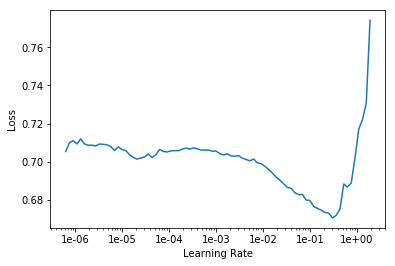

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy
1,0.618813,0.595474,0.682166
2,0.580390,0.563336,0.719108
3,0.574238,0.561447,0.717834
4,0.566379,0.558802,0.718471
5,0.558243,0.560344,0.715924


In [49]:
preds, targets = learn.get_preds(ds_type=DatasetType.Test)

In [50]:
preds_np = preds.cpu().numpy()

In [51]:
pred_targets = np.argmax(preds_np, axis=1)

In [52]:
data.train_ds.y.classes

['GILGFVFTL', 'NLVPMVATV']

In [53]:
truth = tcr_test["antigen.epitope"].map(lambda p: 0 if p=="GILGFVFTL" else 1)

In [54]:
(pred_targets == truth).mean()

0.7131940906775344

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(truth, preds_np[:, 1])

0.7708180313890366

In [56]:
learn.show_results()

v.segm,j.segm,mhc.a,target,prediction
TRBV19*01,TRBJ1-1*01,HLA-A*02,GILGFVFTL,GILGFVFTL
TRBV19*01,TRBJ2-1*01,HLA-A*02,GILGFVFTL,GILGFVFTL
TRBV20-1*01,TRBJ2-1*01,HLA-A*02,NLVPMVATV,NLVPMVATV
TRBV29-1*01,TRBJ1-1*01,HLA-A*02,GILGFVFTL,NLVPMVATV
TRBV7-3*01,TRBJ1-3*01,HLA-A*02,NLVPMVATV,GILGFVFTL


text_data,target,prediction
CASSIGIGEAFF00000000000000000000000000,GILGFVFTL,GILGFVFTL
CASSIYSSSYNEQFF00000000000000000000000,GILGFVFTL,GILGFVFTL
CSANSLSWPGEQFF000000000000000000000000,NLVPMVATV,NLVPMVATV
CSVAGNTEAFF000000000000000000000000000,GILGFVFTL,NLVPMVATV
CASSSRQNSGNTIYF00000000000000000000000,NLVPMVATV,GILGFVFTL


In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth, pred_targets)

Normalized confusion matrix
[[0.622403 0.377597]
 [0.169393 0.830607]]


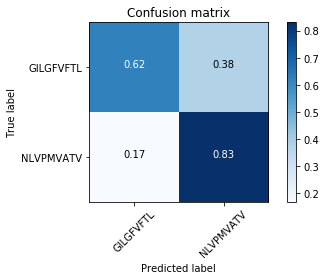

In [59]:
plot_confusion_matrix(cm, data.train_ds.y.classes, normalize=True)